# Information

## Column information

* The vessel's Maritime Mobile Service Identity (MMSI) – a unique nine digit identification number.
* Navigation status – "at anchor", "under way using engine(s)", "not under command", etc.
* Rate of turn – right or left, from 0 to 720 degrees per minute
* Speed over ground – 0.1-knot (0.19 km/h) resolution from 0 to 102 knots (189 km/h)
* Positional accuracy:
* Longitude – to 0.0001 minutes
* Latitude – to 0.0001 minutes
* Course over ground – relative to true north to 0.1°
* True heading – 0 to 359 degrees (for example from a gyro compass)
* True bearing at own position. 0 to 359 degrees
* UTC Seconds – The seconds field of the UTC time when these data were generated. A complete timestamp is not present.


In addition, the following data are broadcast every 6 minutes:

* IMO ship identification number – a seven digit number that remains unchanged upon transfer of the ship's registration to another country
* Radio call sign – international radio call sign, up to seven characters, assigned to the vessel by its country of registry
* Name – 20 characters to represent the name of the vessel
* Type of ship/cargo
* Dimensions of ship – to nearest meter
* Location of positioning system's (e.g., GPS) antenna on board the vessel - in meters aft of bow and meters port or starboard
* Type of positioning system – such as GPS, DGPS or LORAN-C.
* Draught of ship – 0.1 meter to 25.5 meters
* Destination – max. 20 characters
* ETA (estimated time of arrival) at destination – UTC month/date hour:minute
* optional : high precision time request, a vessel can request other vessels provide a high precision UTC time and datestamp


# Initialization

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline

from os import path, getcwd
from glob import glob

In [3]:
code_dir = getcwd()
data_dir = path.expanduser('~/data/workshop-content18/3-snc/data/')

In [4]:
ais_pathnames = glob(data_dir + '*.txt')
ais_basenames = [path.basename(pn) for pn in ais_pathnames]
for bn in ais_basenames:
    print(bn)

PMV_AIS_NewWestminster_Current.txt
PMV_AIS_Deltaport_Current.txt
PMV_AIS_Deltaport_History.txt
PMV_AIS_NewWestminster_History.txt


In [5]:
!ls -l {data_dir}

total 1443544
-rw-rw-r--. 1 jovyan 1000 277236490 Jul 29  2015 PMV_AIS_Deltaport_Current.txt
-rw-rw-r--. 1 jovyan 1000 246584377 Jul 29  2015 PMV_AIS_Deltaport_History.txt
-rw-r--r--. 1 jovyan 1000 244538069 Apr 16 20:37 PMV_AIS_Files.zip
-rw-rw-r--. 1 jovyan 1000 412480776 Jul 29  2015 PMV_AIS_NewWestminster_Current.txt
-rw-rw-r--. 1 jovyan 1000 296033832 Jul 29  2015 PMV_AIS_NewWestminster_History.txt


# Load data

## Just load one for now

First: can we even load a full file? 

In [6]:
delta_cur_basename = next(bn for bn in ais_basenames if 'Deltaport_Current' in bn)
delta_his_basename = next(bn for bn in ais_basenames if 'Deltaport_History' in bn)

In [7]:
max_rows=int(3e6)
delta_cur = pd.read_csv(
    data_dir + delta_cur_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

The last row was missing (I think this is merely because there's an extra line break, but haven't looked too closely). Either way, we need to delete it because it doesn't belong. 

In [8]:
if delta_cur.isna().iloc[-1,:].sum() > 10:
    delta_cur = delta_cur.iloc[:-1, :]

print('# na:', (delta_cur.isna().sum(axis=1) > 5).sum())

# na: 0


...much better.

`UserID` should be categorical. Sometimes things don't play nicely with `pandas` categorical dtype, but seaborn does!

In [9]:
delta_cur.UserID = delta_cur.UserID.astype('category')

In [10]:
delta_cur.shape

(2560654, 12)

There are just more than 2.5 M rows. Only 12 columns (see above for description).

In [11]:
def headsNorTails(dfs):
    """
    cheekily named function for viewing the head and the tail of the data
    """
    dfs = pd.concat((dfs.head(), dfs.tail()))
    if isinstance(dfs, pd.Series):
        dfs = dfs.to_frame()
    return dfs

In [12]:
headsNorTails(delta_cur)

,UserID,NavigationalStatus,ROT,SOG,PositionAccuracy,Longitude,Latitude,COG,TrueHeading,TimeStamp,ReceivedTime,rowid
0,316005621,0.0,-127.0,0.1,0.0,-122.77156,49.23065,32.6,511.0,24.0,2013-10-22 01:05:24.510,311057489.0
1,316018851,0.0,0.0,1.7,0.0,-123.05445,49.29853,67.0,110.0,24.0,2013-10-22 01:05:25.400,311057490.0
2,316003679,2.0,-127.0,0.1,0.0,-123.10751,49.31308,150.8,511.0,24.0,2013-10-22 01:05:25.853,311057491.0
3,316014621,0.0,127.0,12.3,0.0,-123.09534,49.29940,210.7,210.0,26.0,2013-10-22 01:05:26.027,311057492.0
4,316005721,0.0,-127.0,0.1,0.0,-123.10684,49.31094,166.9,511.0,25.0,2013-10-22 01:05:26.620,311057493.0
2560649,316004333,15.0,-127.0,0.0,0.0,-123.18175,49.12306,263.2,511.0,58.0,2013-10-31 23:59:58.853,313618138.0
2560650,477196500,1.0,0.0,0.0,1.0,-123.24473,48.79799,87.8,178.0,58.0,2013-10-31 23:59:59.180,313618139.0
2560651,316013198,0.0,-127.0,0.0,1.0,-123.05972,49.29088,5.1,511.0,59.0,2013-10-31 23:59:59.340,313618140.0
2560652,316020869,0.0,0.0,0.0,1.0,-123.10690,49.31069,34.3,4.0,58.0,2013-10-31 23:59:59.510,313618141.0
2560653,316003447,15.0,-127.0,0.0,0.0,-123.02956,49.29908,236.0,511.0,57.0,2013-10-31 23:59:59.650,313618142.0


But how many points per ship? 

In [13]:
headsNorTails(pd.value_counts(delta_cur.UserID))

,UserID
316014995,70580
316004702,70119
316005727,68144
316023452,64002
316020869,56165
338616000,1
239730000,1
367474610,1
351468288,1
986710691,1


Total number of rows corresponding to `UserID`s having fewer than 1000 data points:

In [14]:
UserID_ValueCounts = pd.value_counts(delta_cur.UserID)
UserID_ValueCounts.loc[UserID_ValueCounts < 1000].values.sum()

48856

**Look at Lon-Lat values**

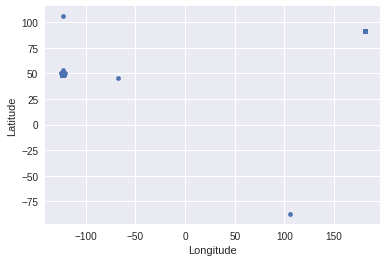

In [15]:
delta_cur.plot.scatter('Longitude', 'Latitude');

There's this many points that are broadcasting from the North Pole:

In [16]:
(delta_cur.Latitude > 80).sum()

57772

Let's get rid of them because they don't belong in the Vancouver harbour — who knows what else is 'off' with them

In [17]:
delta_cur = delta_cur.loc[delta_cur.Latitude < 80]

<div class="alert alert-block alert-info">
**Note:** get rid of `UserID`s that only appear once — I doubt we can do anything with these.
</div>

In [18]:
nPoints_by_UserID = pd.value_counts(delta_cur.UserID)

In [19]:
nPoints_threshold = 1000
print('num rows for which userid count <= 1000:', nPoints_by_UserID.loc[nPoints_by_UserID <= 1000].values.sum())
userID_allowed = nPoints_by_UserID.index[nPoints_by_UserID > nPoints_threshold]

num rows for which userid count <= 1000: 48845


In [20]:
userID_allowed.values.remove_unused_categories(inplace=True)

In [21]:
delta_cur = delta_cur.loc[delta_cur.UserID.apply(lambda x: x in userID_allowed.values)]

**Checking plot again**

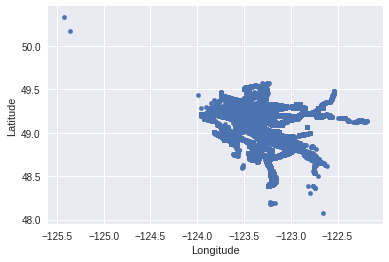

In [22]:
delta_cur.plot.scatter('Longitude', 'Latitude');

**Format dates**

In [23]:
ReceivedDate = delta_cur.ReceivedTime.dt.date
ReceivedDate_ValueCounts = pd.value_counts(ReceivedDate)
ReceivedDate_ValueCounts.to_frame()

,ReceivedTime
2013-10-23,276045
2013-10-29,267727
2013-10-22,266404
2013-10-27,259420
2013-10-28,253972
2013-10-26,238035
2013-10-30,237996
2013-10-31,237442
2013-10-25,220591
2013-10-24,196405


In [24]:
delta_cur['ReceivedDay'] = ReceivedDate.apply(lambda x: x.day)

Next we'd really like to know about the distributions of how many records are sent for each ship on each day. To do this, let's count the number of records on each ship on each day and then make a swarm plot / violin plot / box plot for each day where there are recording. We expect right-skew, and hope that the results suggest some kind of "natural cut-off" value - we can select all UserIDs with a sufficiently high number of records and maybe just work with those.

In [25]:
sns.set(style="whitegrid", color_codes=True)

In [26]:
df_grp = delta_cur.groupby(['ReceivedDay', 'UserID'])

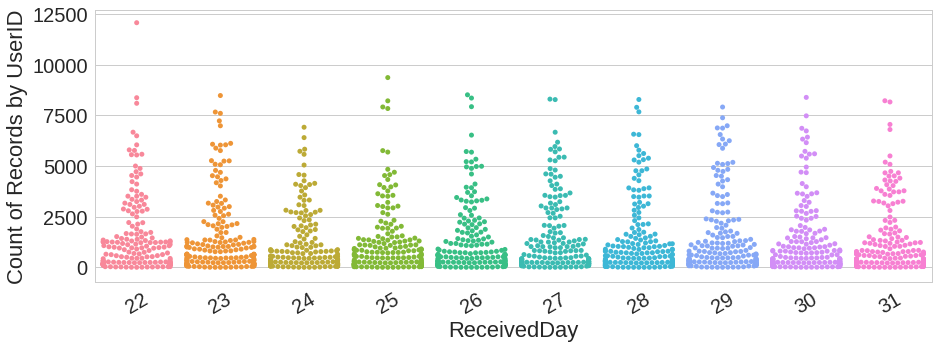

In [27]:
sns.set(style='whitegrid', font_scale=2)
plt.figure(figsize=(15, 5))
ax = sns.swarmplot(
    x='ReceivedDay', y='ROT', 
    data=df_grp['ROT'].count().reset_index())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_ylabel('Count of Records by UserID');

Great. So for playing around, we could probably look at those UserIDs with only 1500 or more records. 

In [28]:
# code to do that here:




Let's plot records of ships just on the 22nd

In [29]:
delta_cur_22 = delta_cur.loc[delta_cur.ReceivedDay == 22, :]

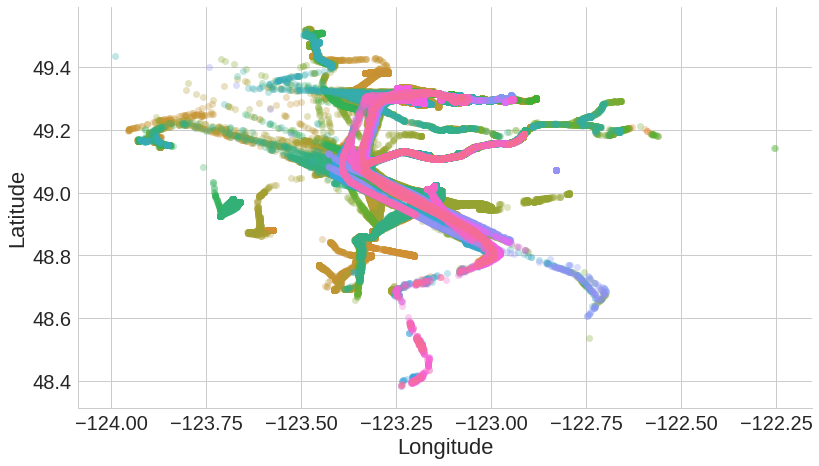

In [30]:
sns.lmplot('Longitude', 'Latitude', hue='UserID', 
           data=delta_cur_22, legend=False, fit_reg=False,
           size=7, aspect=1.7, scatter_kws={'alpha':.3});

Great. After some playing around with axis limits, we can finally see some ship trajectories. There are so many unique ship IDs that I chose not to include a legend. Also, there are some ships with erroneous Lon-Lat readings, which I believe were the cause for me having to play around with the axis limits. 

# To-Do:

* Subset the dataframe to remove any points that have Lon-Lat readings outside of (-127, -120) x (48, 50)
    * (Write code for this and upload it to the repository. We'll eventually have to port this approach to the other data.)
* Subset the dataframe to remove any UserIDs that have fewer than 1000 records
    * (Write code for this and upload it to the repository. We'll eventually have to port this approach to the other data.)
* Group the data by day and for each subgroup, remove any UserIDs that have fewer than ¿10? records
    * (Write code for this and upload it to the repository. We'll eventually have to port this approach to the other data.)
* Make a scatter plot for each day there is recorded data (cf. seaborn.FacetGrid or seaborn.FacetPlot or whatever it is)
    * Make a plot for each day with a **line** for each ship (instead of dots for each ship)
    * Add arrows at each (lon, lat) point denoting the ships heading (see the top of this document for a description pointing you to the relevant column)
    * Save the plot(s) you've made and upload them as pngs to the repository. 
* See if you can find out how to turn the ship's trajectory into a Bezier curve. I've not really played around with Bezier curves, but I know that they could be a useful tool for one possible solution for this project. Basically, each ship trajectory can be represented as an object called a "Bezier curve", all of which can be parametrized by a fixed number of values. This let's us compare ship trajectories by comparing parameter values for the Bezier curves. [This site](http://devmag.org.za/2011/06/23/bzier-path-algorithms/) looks like a great introduction to the idea. 
    * If you have code or images (or better references!) for this, upload it in any format to the repository. We'll need it for the other data / and/or the participants will need to know how to modify the approach to work with the other crazy ideas I have :D

# One Ship

In [31]:
data = pd.DataFrame(delta_cur, columns = ['UserID','Longitude','Latitude'])

# All ships:
data.UserID

0          316005621
1          316018851
2          316003679
3          316014621
4          316005721
5          316014803
6          316014995
7          316001245
8          316006154
9          316005622
10         316003900
11         316018851
12         316005726
13         316003600
14         316011982
15         316020869
17         316018851
18         371540000
19         477403000
20         316005668
21         316005727
22         316021351
23         316018851
24         316005621
25         316014621
26         316014995
27         316022038
28         352779000
30         316005625
31         316006154
             ...    
2560619    316014621
2560620    316003667
2560622    316014995
2560623    316005727
2560625    316014803
2560626    316020868
2560627    316003900
2560628    316003656
2560629    316004702
2560630    316005616
2560631    316004333
2560632    371795000
2560633    316001245
2560634    371540000
2560635    316013397
2560636    316005651
2560637    31

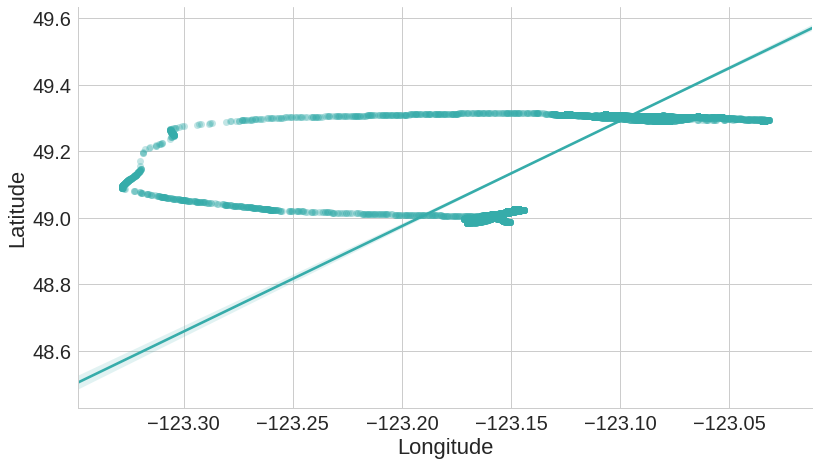

In [32]:
# One ship:
data_one = data.loc[data['UserID'] == '316020869']
sns.lmplot('Longitude', 'Latitude', hue='UserID', 
           data=data_one, legend=False, fit_reg=True,
           size=7, aspect=1.7, scatter_kws={'alpha':.3});

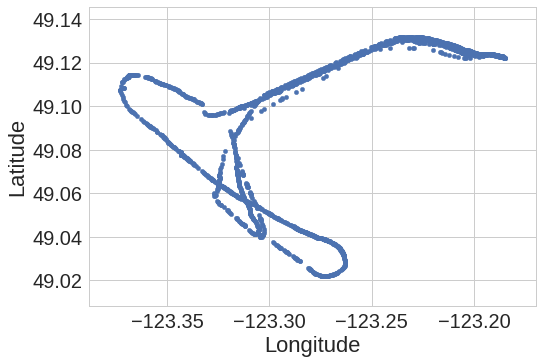

In [38]:
UserID_22_vc = pd.value_counts(delta_cur_22.UserID)
delta_22_316020869 = (delta_cur_22
                      .loc[delta_cur_22.UserID == UserID_22_vc.index[1]])

delta_22_316020869.plot.scatter('Longitude', 'Latitude');

delta_22_316020869_sparse = (delta_22_316020869
                             .reset_index(drop=True)
                             .iloc[::10, :]
                             .reset_index(drop=True))
m = folium.Map(location=[49, -123.7], 
               tiles='Stamen Terrain', zoom_start=9)
latlon = zip(delta_22_316020869_sparse.Latitude.values, 
             delta_22_316020869_sparse.Longitude.values)
for coord in latlon:
    folium.Circle(location=coord, fill=True).add_to(m)
m